<a href="https://colab.research.google.com/github/mildsupitcha25/MachineLearning_phishing_email/blob/main/ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#XGBoost

กำลังโหลดข้อมูลจาก GitHub...
โหลดข้อมูลสำเร็จ!
Train Shape: (100, 3)
Test  Shape: (26, 3)
Train TF-IDF shape: (100, 30711) | Test TF-IDF shape: (26, 30711)

กำลังค้นหา hyperparameters เพื่อดัน Recall...
Fitting 3 folds for each of 7 candidates, totalling 21 fits
Best Params: {'C': np.float64(2.1544346900318834)}

[Validation @ threshold=0.5]
Accuracy : 1.0
Recall   : 1.0
Precision: 1.0
ROC-AUC  : 1.0
PR-AUC   : 0.9999999999999999
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00        10
    Phishing       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20


[Validation @ tuned threshold=0.580] (target recall ≥ 0.95)
Accuracy : 1.0
Recall   : 1.0
Precision: 1.0
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00        10
    Phishing       1.00 

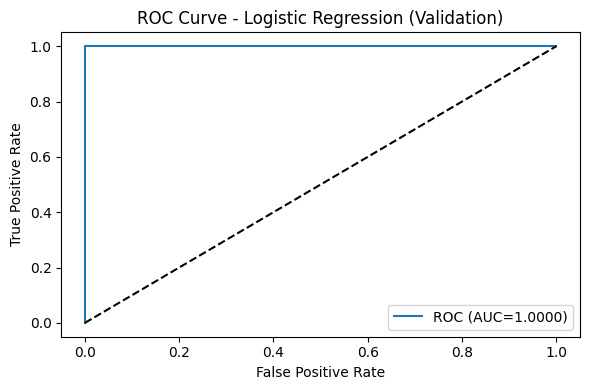

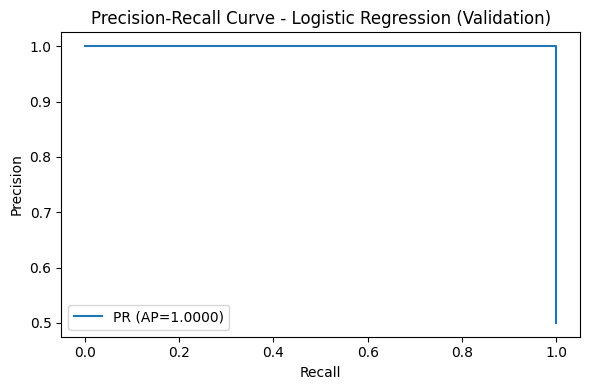


--- ผลลัพธ์ทำนาย (20 แถวแรก) ---
                                              Subject       Label  \
0   Exclusive Personal Relationship Opportunity Ju...  Legitimate   
1   Exceptional Work-From-Home Job Opportunity Awa...    Phishing   
2   Notification of Recent Account Activity - Acti...  Legitimate   
3   Exciting Work-from-Home Job Opportunity: Immed...    Phishing   
4   Exclusive Promotional Offer Just for You, Lind...  Legitimate   
5   Exclusive Promotional Offer from "Dynamic Glob...    Phishing   
6   Exciting Job Opportunity Awaits You at [Organi...  Legitimate   
7   Fantastic Work-From-Home Opportunity at BellaN...    Phishing   
8   Urgent Update Required for Your Health Managem...    Phishing   
9   Exciting Job Opportunity and Immediate Action ...    Phishing   
10        Immediate Job Opportunity at Tech Solutions    Phishing   
11        Important Technical Update - Security Alert    Phishing   
12  Important Account Notification - Please Review...  Legitimate   


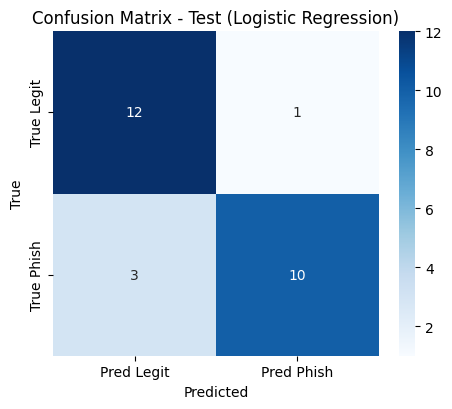


✅ บันทึกไฟล์: test_predictions_lr_recall.csv


In [4]:
# ==============================
# 1) Import Libraries
# ==============================
import pandas as pd
import numpy as np

from scipy.sparse import hstack

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score, confusion_matrix,
    fbeta_score, recall_score, precision_score
)

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


# ==============================
# 2) Load Data
# ==============================
TRAIN_URL = 'https://raw.githubusercontent.com/mildsupitcha25/MachineLearning_phishing_email/main/train.csv'
TEST_URL  = 'https://raw.githubusercontent.com/mildsupitcha25/MachineLearning_phishing_email/main/test.csv'

print("กำลังโหลดข้อมูลจาก GitHub...")
train_df = pd.read_csv(TRAIN_URL)
test_df  = pd.read_csv(TEST_URL)
print("โหลดข้อมูลสำเร็จ!")
print(f"Train Shape: {train_df.shape}")
print(f"Test  Shape: {test_df.shape}")

# ==============================
# 3) Prepare Data
# ==============================
# รวม Subject + Body (ไม่มี handcrafted features)
train_df['FullText'] = train_df['Subject'].fillna('') + ' ' + train_df['Body'].fillna('')
test_df['FullText']  = test_df['Subject'].fillna('')  + ' ' + test_df['Body'].fillna('')

label_mapping = {'Legitimate': 0, 'Phishing': 1}
train_df['label_num'] = train_df['Label'].map(label_mapping)

if train_df['label_num'].isna().any():
    bad = train_df.loc[train_df['label_num'].isna(), 'Label'].unique()
    raise ValueError(f"พบ Label ใน train ที่ไม่รู้จัก: {bad}")

X_text = train_df['FullText'].fillna('')
y      = train_df['label_num'].astype(int)
X_test_text = test_df['FullText'].fillna('')

# test มี label จริงให้เทียบหรือไม่
test_has_label = False
if 'Label' in test_df.columns:
    test_df['label_num'] = test_df['Label'].map(label_mapping)
    if test_df['label_num'].isna().any():
        bad = test_df.loc[test_df['label_num'].isna(), 'Label'].unique()
        raise ValueError(f"พบ Label ใน test ที่ไม่รู้จัก: {bad}")
    test_has_label = True

# ==============================
# 4) TF-IDF (word + char n-grams) — ไม่มีฟีเจอร์ทำมือ
# ==============================
word_vec = TfidfVectorizer(
    stop_words='english',
    lowercase=True,
    max_features=40000,
    ngram_range=(1, 3),
    min_df=2,
    max_df=0.98,
    sublinear_tf=True
)
char_vec = TfidfVectorizer(
    analyzer='char',
    lowercase=True,
    ngram_range=(3, 5),
    min_df=2
)

X_word = word_vec.fit_transform(X_text)       # fit เฉพาะ train
X_char = char_vec.fit_transform(X_text)
X_all  = hstack([X_word, X_char]).tocsr()

X_word_test = word_vec.transform(X_test_text) # transform test
X_char_test = char_vec.transform(X_test_text)
X_test_all  = hstack([X_word_test, X_char_test]).tocsr()

print(f"Train TF-IDF shape: {X_all.shape} | Test TF-IDF shape: {X_test_all.shape}")

# ==============================
# 5) Split Train/Validation
# ==============================
X_tr, X_val, y_tr, y_val = train_test_split(
    X_all, y, test_size=0.2, random_state=42, stratify=y
)

# ==============================
# 6) Model: Logistic Regression (balanced) + Tuning for Recall
# ==============================
logreg = LogisticRegression(
    solver='saga',            # รองรับ L1/L2 และปรับ class_weight ได้ดี
    penalty='l2',
    class_weight='balanced',  # เน้นช่วย class น้อย (phishing)
    max_iter=5000,
    n_jobs=-1
)

param_dist = {
    'C': np.logspace(-1, 1, 7),         # [0.1..10]
    # 'penalty': ['l2'],                # (เปิด L1 ถ้าต้องการ feature selection แบบสปาร์เซ)
}

search = RandomizedSearchCV(
    estimator=logreg,
    param_distributions=param_dist,
    n_iter=10,
    scoring='recall',          # โฟกัส recall ของ class 1
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

print("\nกำลังค้นหา hyperparameters เพื่อดัน Recall...")
search.fit(X_tr, y_tr)
best_lr = search.best_estimator_
print("Best Params:", search.best_params_)

# ==============================
# 7) Validation Metrics + Threshold Tuning (เน้น Recall)
# ==============================
val_prob = best_lr.predict_proba(X_val)[:, 1]

# เกณฑ์ 1: ใช้ threshold 0.5 (baseline)
val_pred_05 = (val_prob >= 0.5).astype(int)
print("\n[Validation @ threshold=0.5]")
print("Accuracy :", accuracy_score(y_val, val_pred_05))
print("Recall   :", recall_score(y_val, val_pred_05))
print("Precision:", precision_score(y_val, val_pred_05, zero_division=0))
print("ROC-AUC  :", roc_auc_score(y_val, val_prob))
print("PR-AUC   :", average_precision_score(y_val, val_prob))
print(classification_report(y_val, val_pred_05, target_names=['Legitimate', 'Phishing']))

# เกณฑ์ 2: ปรับ threshold ให้ได้ Recall สูง (เช่น >= 0.95) โดยพยายามรักษา precision ให้มากที่สุด
TARGET_RECALL = 0.95
prec, rec, thr = precision_recall_curve(y_val, val_prob)

# เลือก threshold ที่ให้ recall >= TARGET_RECALL และ precision สูงสุด
best_t = 0.5
best_prec = -1.0
for p, r, t in zip(prec[:-1], rec[:-1], thr):
    if r >= TARGET_RECALL and p > best_prec:
        best_prec = p
        best_t = t

# ถ้าหา threshold ที่ผ่านเป้า recall ไม่ได้ ให้ fallback เป็น threshold ที่ maximize F2
if best_prec < 0:
    thresholds = np.linspace(0.05, 0.95, 181)
    f2_scores = [fbeta_score(y_val, (val_prob >= t).astype(int), beta=2)
                 for t in thresholds]
    best_t = float(thresholds[int(np.argmax(f2_scores))])
    mode = f"(fallback) F2-optimal"
else:
    mode = f"(target recall ≥ {TARGET_RECALL:.2f})"

val_pred_best = (val_prob >= best_t).astype(int)

print(f"\n[Validation @ tuned threshold={best_t:.3f}] {mode}")
print("Accuracy :", accuracy_score(y_val, val_pred_best))
print("Recall   :", recall_score(y_val, val_pred_best))
print("Precision:", precision_score(y_val, val_pred_best, zero_division=0))
print(classification_report(y_val, val_pred_best, target_names=['Legitimate', 'Phishing']))

# Plot ROC
fpr, tpr, _ = roc_curve(y_val, val_prob)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC (AUC={roc_auc_score(y_val, val_prob):.4f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression (Validation)')
plt.legend(); plt.tight_layout(); plt.show()

# Plot PR
plt.figure(figsize=(6,4))
plt.plot(rec, prec, label=f'PR (AP={average_precision_score(y_val, val_prob):.4f})')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Logistic Regression (Validation)')
plt.legend(); plt.tight_layout(); plt.show()

# ==============================
# 8) Refit บน Train ทั้งหมด + Predict Test (ใช้ threshold ที่ tune มา)
# ==============================
# ใช้พารามิเตอร์ที่ดีที่สุด refit บน train ทั้งหมด
final_lr = LogisticRegression(
    solver='saga',
    penalty='l2',
    class_weight='balanced',
    max_iter=5000,
    n_jobs=-1,
    C=search.best_params_['C']
).fit(X_all, y)

test_prob = final_lr.predict_proba(X_test_all)[:, 1]
test_pred = (test_prob >= best_t).astype(int)

# แนบผล
submission_df = test_df.copy()
submission_df['Predicted_Prob_Phishing'] = test_prob
submission_df['Predicted_Label_Num']     = test_pred
rev_map = {0: 'Legitimate', 1: 'Phishing'}
submission_df['Predicted_Label'] = submission_df['Predicted_Label_Num'].map(rev_map)

# แสดงพรีวิว
show_cols = ['Subject', 'Predicted_Label', 'Predicted_Prob_Phishing']
if test_has_label:
    show_cols.insert(1, 'Label')
print("\n--- ผลลัพธ์ทำนาย (20 แถวแรก) ---")
print(submission_df[show_cols].head(20))
print("\nจำนวนทั้งหมด:", len(submission_df))

# ===== Evaluate on TEST (ถ้ามี Label จริง) =====
if test_has_label:
    print("\n[Evaluation on TEST Set]")
    print(f"Threshold used: {best_t:.3f}")
    print("Accuracy :", accuracy_score(submission_df['label_num'], test_pred))
    print("Recall   :", recall_score(submission_df['label_num'], test_pred))
    print("Precision:", precision_score(submission_df['label_num'], test_pred, zero_division=0))
    print(classification_report(
        submission_df['label_num'], test_pred, target_names=['Legitimate', 'Phishing']
    ))

    # Confusion Matrix
    cm = confusion_matrix(submission_df['label_num'], test_pred, labels=[0,1])
    plt.figure(figsize=(4.8,4.2))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred Legit', 'Pred Phish'],
                yticklabels=['True Legit', 'True Phish'])
    plt.title('Confusion Matrix - Test (Logistic Regression)')
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.tight_layout(); plt.show()
else:
    print("\n⚠️ Test set ไม่มี Label จริง จึงประเมิน metrics ไม่ได้ (จะแสดงเฉพาะผลทำนาย)")

# ==============================
# 9) Save Predictions
# ==============================
id_col = None
if 'Id' in test_df.columns: id_col = 'Id'
elif 'ID' in test_df.columns: id_col = 'ID'
else:
    submission_df['Index'] = submission_df.index
    id_col = 'Index'

out_cols = [id_col, 'Predicted_Label', 'Predicted_Prob_Phishing']
if test_has_label:
    out_cols.insert(1, 'Label')

submission_df[out_cols].to_csv('test_predictions_lr_recall.csv', index=False)
print("\n✅ บันทึกไฟล์: test_predictions_lr_recall.csv")


#Naive Bayes
+ SMOTE + Cross-validation + AUC/ROC + Predict Test Set


กำลังโหลดข้อมูล...
โหลดข้อมูลสำเร็จ!
Train Shape: (100, 3), Test Shape: (26, 3)
ก่อน SMOTE: {0: 40, 1: 40}
หลัง SMOTE: {0: 40, 1: 40}

Cross-Validation Accuracy: 0.9600 ± 0.0374
Cross-Validation AUC: 1.0000 ± 0.0000

[Validation Set]
Accuracy: 1.0
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00        10
    Phishing       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

AUC Score: 1.0000


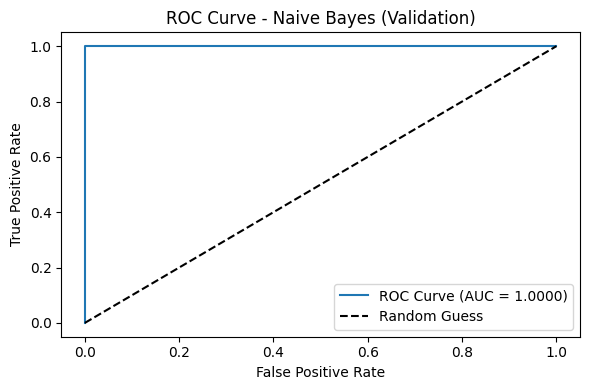


--- ผลลัพธ์การทำนาย Test Set (20 แถวแรก) ---
                                              Subject Predicted_Label  \
0   Exclusive Personal Relationship Opportunity Ju...      Legitimate   
1   Exceptional Work-From-Home Job Opportunity Awa...      Legitimate   
2   Notification of Recent Account Activity - Acti...      Legitimate   
3   Exciting Work-from-Home Job Opportunity: Immed...        Phishing   
4   Exclusive Promotional Offer Just for You, Lind...      Legitimate   
5   Exclusive Promotional Offer from "Dynamic Glob...        Phishing   
6   Exciting Job Opportunity Awaits You at [Organi...      Legitimate   
7   Fantastic Work-From-Home Opportunity at BellaN...      Legitimate   
8   Urgent Update Required for Your Health Managem...        Phishing   
9   Exciting Job Opportunity and Immediate Action ...      Legitimate   
10        Immediate Job Opportunity at Tech Solutions        Phishing   
11        Important Technical Update - Security Alert        Phishing   
12  I

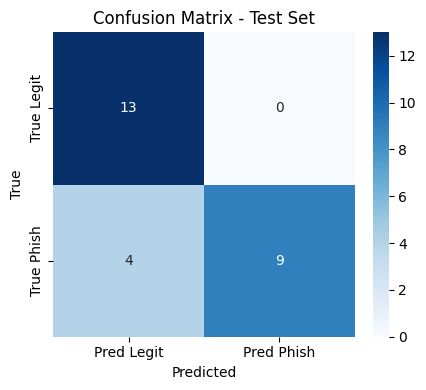


✅ บันทึกผลลัพธ์ในไฟล์: test_predictions_nb.csv


In [1]:
# ==============================
# 1. Import Libraries
# ==============================
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score, classification_report, roc_auc_score, roc_curve,
    confusion_matrix
)
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')  # ✅ ปิด Warning

# ==============================
# 2. Load Data
# ==============================
TRAIN_URL = 'https://raw.githubusercontent.com/mildsupitcha25/MachineLearning_phishing_email/main/train.csv'
TEST_URL = 'https://raw.githubusercontent.com/mildsupitcha25/MachineLearning_phishing_email/main/test.csv'

print("\nกำลังโหลดข้อมูล...")
train_df = pd.read_csv(TRAIN_URL)
test_df = pd.read_csv(TEST_URL)
print("โหลดข้อมูลสำเร็จ!")
print(f"Train Shape: {train_df.shape}, Test Shape: {test_df.shape}")

# ตรวจสอบคอลัมน์ที่จำเป็น
required_cols = ['Subject', 'Body', 'Label']
missing_train = [c for c in required_cols if c not in train_df.columns]
missing_test_for_eval = [c for c in required_cols if c not in test_df.columns]

if missing_train:
    raise ValueError(f"Train file ขาดคอลัมน์: {missing_train}")
if missing_test_for_eval:
    print(f"⚠️ Test file ไม่มีคอลัมน์สำหรับประเมิน: {missing_test_for_eval}")
    print("โค้ดจะยังสามารถทำนาย test ได้ แต่จะไม่คำนวณ metrics เทียบกับ label จริงของ test set")

# ==============================
# 3. Data Preparation
# ==============================
# รวม Subject + Body เป็นฟีเจอร์ข้อความเดียว
train_df['FullText'] = train_df['Subject'].fillna('') + ' ' + train_df['Body'].fillna('')
test_df['FullText'] = test_df['Subject'].fillna('') + ' ' + test_df['Body'].fillna('')

# เข้ารหัส Label
label_mapping = {'Legitimate': 0, 'Phishing': 1}
train_df['label_num'] = train_df['Label'].map(label_mapping)

# ตรวจ Missing/Unmapped labels
if train_df['label_num'].isna().any():
    bad = train_df[train_df['label_num'].isna()]['Label'].unique()
    raise ValueError(f"พบ Label ใน train ที่ไม่รู้จัก: {bad}. โปรดอัปเดต label_mapping")

X = train_df['FullText']
y = train_df['label_num']
X_test = test_df['FullText']

# ถ้า test มี Label จริง ให้แมปด้วย
test_has_label = False
if 'Label' in test_df.columns:
    test_df['label_num'] = test_df['Label'].map(label_mapping)
    if test_df['label_num'].isna().any():
        bad = test_df[test_df['label_num'].isna()]['Label'].unique()
        raise ValueError(f"พบ Label ใน test ที่ไม่รู้จัก: {bad}. โปรดอัปเดต label_mapping")
    else:
        test_has_label = True

# ==============================
# 4. TF-IDF Vectorization
# ==============================
vectorizer = TfidfVectorizer(
    stop_words='english',
    lowercase=True,
    max_features=5000,
    ngram_range=(1, 2)
)
X_vec = vectorizer.fit_transform(X)        # fit บน train เท่านั้น
X_test_vec = vectorizer.transform(X_test)  # transform บน test

# ==============================
# 5. Train/Validation Split + SMOTE
# ==============================
X_train, X_val, y_train, y_val = train_test_split(
    X_vec, y, test_size=0.2, random_state=42, stratify=y
)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("ก่อน SMOTE:", y_train.value_counts().to_dict())
print("หลัง SMOTE:", pd.Series(y_train_resampled).value_counts().to_dict())

# ==============================
# 6. Cross-validation (Accuracy & AUC)
# ==============================
nb_model = MultinomialNB(alpha=0.5)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracy_scores = cross_val_score(nb_model, X_vec, y, cv=cv, scoring='accuracy')
auc_scores = cross_val_score(nb_model, X_vec, y, cv=cv, scoring='roc_auc')

print(f"\nCross-Validation Accuracy: {np.mean(accuracy_scores):.4f} ± {np.std(accuracy_scores):.4f}")
print(f"Cross-Validation AUC: {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}")

# ==============================
# 7. Train Final Model & ROC Curve (Validation)
# ==============================
nb_model.fit(X_train_resampled, y_train_resampled)
y_val_pred = nb_model.predict(X_val)
y_val_prob = nb_model.predict_proba(X_val)[:, 1]

print("\n[Validation Set]")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred, target_names=['Legitimate', 'Phishing']))

val_auc_score = roc_auc_score(y_val, y_val_prob)
print(f"AUC Score: {val_auc_score:.4f}")

fpr, tpr, thresholds = roc_curve(y_val, y_val_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {val_auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Naive Bayes (Validation)')
plt.legend()
plt.tight_layout()
plt.show()

# ==============================
# 8. Predict on Test Set + (Optional) Evaluate vs True Labels
# ==============================
y_test_prob = nb_model.predict_proba(X_test_vec)[:, 1]
y_test_pred = (y_test_prob >= 0.5).astype(int)  # ใช้ threshold 0.5 (ปรับได้)

test_df['Predicted_Label_Num'] = y_test_pred
reverse_label_mapping = {v: k for k, v in label_mapping.items()}
test_df['Predicted_Label'] = test_df['Predicted_Label_Num'].map(reverse_label_mapping)
test_df['Predicted_Prob_Phishing'] = y_test_prob

print("\n--- ผลลัพธ์การทำนาย Test Set (20 แถวแรก) ---")
cols_show = ['Subject', 'Predicted_Label', 'Predicted_Prob_Phishing']
if test_has_label:
    cols_show += ['Label']
print(test_df[cols_show].head(20))

# ===== Evaluate on Test (ถ้ามี Label จริง) =====
if test_has_label:
    print("\n[Evaluation on TEST Set]")
    test_acc = accuracy_score(test_df['label_num'], y_test_pred)
    print(f"Test Accuracy: {test_acc:.4f}")

    print(classification_report(
        test_df['label_num'], y_test_pred, target_names=['Legitimate', 'Phishing']
    ))

    try:
        test_auc = roc_auc_score(test_df['label_num'], y_test_prob)
        print(f"Test AUC: {test_auc:.4f}")
    except ValueError:
        print("ไม่สามารถคำนวณ AUC ได้ (อาจเป็นเพราะมี class เดียวใน test)")

    # Confusion Matrix
    cm = confusion_matrix(test_df['label_num'], y_test_pred, labels=[0, 1])
    plt.figure(figsize=(4.5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred Legit', 'Pred Phish'],
                yticklabels=['True Legit', 'True Phish'])
    plt.title('Confusion Matrix - Test Set')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️ Test set ไม่มี Label จริง จึงประเมิน metrics ไม่ได้")

# ==============================
# 9. Save Outputs
# ==============================
# ไฟล์ผลลัพธ์การทำนาย (รวม prob)
out_cols = ['Subject', 'Predicted_Label', 'Predicted_Prob_Phishing']
if test_has_label:
    out_cols = ['Subject', 'Label', 'Predicted_Label', 'Predicted_Prob_Phishing']
test_df[out_cols].to_csv('test_predictions_nb.csv', index=False)
print("\n✅ บันทึกผลลัพธ์ในไฟล์: test_predictions_nb.csv")

#Random forest เทียบกับ test set จริง

กำลังโหลดข้อมูลจาก GitHub...
โหลดข้อมูลสำเร็จ!
Train Shape: (100, 3) | Test Shape: (26, 3)
Train TF-IDF shape: (100, 30711) | Test TF-IDF shape: (26, 30711)
Selected features shape: (100, 20000)

กำลังทำ Hyperparameter Tuning (RandomForest) โดยเน้น Recall...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Params: {'n_estimators': 600, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20}

[Validation @ threshold=0.5]
Accuracy : 1.0
Recall   : 1.0
Precision: 1.0
ROC-AUC  : 1.0
PR-AUC   : 0.9999999999999999
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00        10
    Phishing       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20


[Validation @ tuned threshold=0.614] (target recall ≥ 0.95)
Accuracy : 1.0
Recall   : 1.0
Precision: 1.0
   

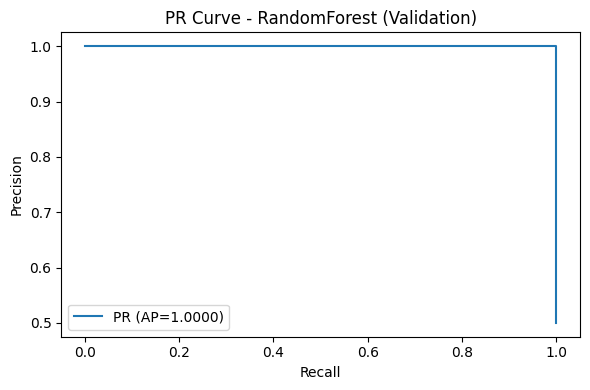

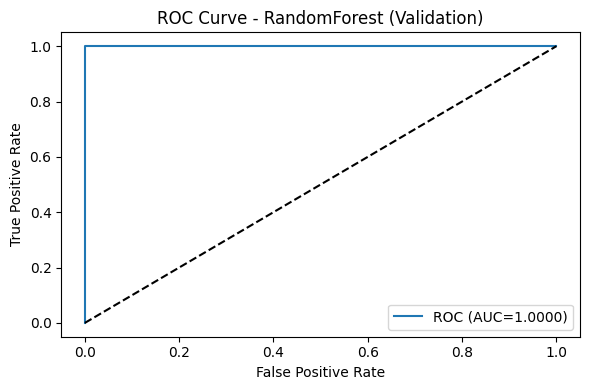


--- ผลลัพธ์การทำนาย Test Set (20 แถวแรก) ---
                                              Subject       Label  \
0   Exclusive Personal Relationship Opportunity Ju...  Legitimate   
1   Exceptional Work-From-Home Job Opportunity Awa...    Phishing   
2   Notification of Recent Account Activity - Acti...  Legitimate   
3   Exciting Work-from-Home Job Opportunity: Immed...    Phishing   
4   Exclusive Promotional Offer Just for You, Lind...  Legitimate   
5   Exclusive Promotional Offer from "Dynamic Glob...    Phishing   
6   Exciting Job Opportunity Awaits You at [Organi...  Legitimate   
7   Fantastic Work-From-Home Opportunity at BellaN...    Phishing   
8   Urgent Update Required for Your Health Managem...    Phishing   
9   Exciting Job Opportunity and Immediate Action ...    Phishing   
10        Immediate Job Opportunity at Tech Solutions    Phishing   
11        Important Technical Update - Security Alert    Phishing   
12  Important Account Notification - Please Review...  Le

In [5]:
# ==============================
# 1) Import Libraries
# ==============================
import pandas as pd
import numpy as np

from scipy.sparse import hstack

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    recall_score, precision_score, roc_auc_score,
    precision_recall_curve, average_precision_score
)
from sklearn.feature_selection import SelectKBest, chi2

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


# ==============================
# 2) Load Data
# ==============================
TRAIN_URL = 'https://raw.githubusercontent.com/mildsupitcha25/MachineLearning_phishing_email/main/train.csv'
TEST_URL  = 'https://raw.githubusercontent.com/mildsupitcha25/MachineLearning_phishing_email/main/test.csv'

print("กำลังโหลดข้อมูลจาก GitHub...")
train_df = pd.read_csv(TRAIN_URL)
test_df  = pd.read_csv(TEST_URL)
print("โหลดข้อมูลสำเร็จ!")
print(f"Train Shape: {train_df.shape} | Test Shape: {test_df.shape}")

# ==============================
# 3) Prepare Data (ไม่มี handcrafted features)
# ==============================
# รวม Subject + Body
train_df['FullText'] = train_df['Subject'].fillna('') + ' ' + train_df['Body'].fillna('')
test_df['FullText']  = test_df['Subject'].fillna('')  + ' ' + test_df['Body'].fillna('')

label_mapping = {'Legitimate': 0, 'Phishing': 1}
train_df['Label_num'] = train_df['Label'].map(label_mapping)

if train_df['Label_num'].isna().any():
    bad = train_df.loc[train_df['Label_num'].isna(), 'Label'].unique()
    raise ValueError(f"พบ Label ใน train ที่ไม่รู้จัก: {bad}")

X_text = train_df['FullText'].fillna('')
y      = train_df['Label_num'].astype(int)

X_test_text  = test_df['FullText'].fillna('')
y_test_true  = test_df['Label'].map(label_mapping) if 'Label' in test_df.columns else None
test_has_label = y_test_true is not None and not y_test_true.isna().any()

# ==============================
# 4) TF-IDF (word + char n-grams) + (optional) SelectKBest
# ==============================
# Word n-grams: 1–3, Char n-grams: 3–5 เพื่อจับ pattern phishing และ obfuscation โดยไม่ใช้ฟีเจอร์ทำมือ
word_vec = TfidfVectorizer(
    stop_words='english',
    lowercase=True,
    max_features=30000,          # เพิ่มความละเอียดจาก 5k
    ngram_range=(1, 3),
    min_df=2,
    max_df=0.98,
    sublinear_tf=True
)
char_vec = TfidfVectorizer(
    analyzer='char',
    lowercase=True,
    ngram_range=(3, 5),
    min_df=2
)

X_word = word_vec.fit_transform(X_text)    # fit เฉพาะ train (ป้องกัน leakage)
X_char = char_vec.fit_transform(X_text)
X_all  = hstack([X_word, X_char]).tocsr()

X_word_test = word_vec.transform(X_test_text)  # transform test
X_char_test = char_vec.transform(X_test_text)
X_test_all  = hstack([X_word_test, X_char_test]).tocsr()

print(f"Train TF-IDF shape: {X_all.shape} | Test TF-IDF shape: {X_test_all.shape}")

# ===== Optional: Feature Selection (Chi2 บน sparse เหมาะ) =====
# ใช้เฉพาะ train แล้ว transform test เพื่อหลีกเลี่ยง leakage
selector = SelectKBest(chi2, k=min(20000, X_all.shape[1]))  # เพิ่มจาก 2k เป็น 20k (ถ้าเฟีเจอร์เยอะ)
X_sel      = selector.fit_transform(X_all, y)
X_test_sel = selector.transform(X_test_all)
print(f"Selected features shape: {X_sel.shape}")

# ==============================
# 5) Split Train/Validation
# ==============================
X_tr, X_val, y_tr, y_val = train_test_split(
    X_sel, y, test_size=0.2, random_state=42, stratify=y
)

# ==============================
# 6) Random Forest + Hyperparameter Tuning (โฟกัส Recall)
# ==============================
# หมายเหตุ: RF บน TF-IDF sparse อาจช้าถ้า n_estimators สูงมาก
rf_base = RandomForestClassifier(
    n_estimators=600,                 # เพิ่มจำนวนต้นไม้
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',             # ช่วย generalize บน text vector
    bootstrap=True,
    class_weight='balanced_subsample',  # โอเวอร์เวทคลาสน้อยในแต่ละ bootstrap
    n_jobs=-1,
    random_state=42
)

param_dist = {
    'n_estimators': [600, 800, 1000],
    'max_depth': [None, 20, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.2, 0.3],  # fractional max_features ใช้ได้
}

search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=20,
    scoring='recall',        # โฟกัส recall ของคลาส phishing
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

print("\nกำลังทำ Hyperparameter Tuning (RandomForest) โดยเน้น Recall...")
search.fit(X_tr, y_tr)
best_rf = search.best_estimator_
print("Best Params:", search.best_params_)

# ==============================
# 7) Validation Metrics + Threshold Tuning (ดัน Recall)
# ==============================
# RF รองรับ predict_proba -> เราปรับ threshold เพื่อดัน recall
val_prob = best_rf.predict_proba(X_val)[:, 1]

# baseline @ 0.5
val_pred_05 = (val_prob >= 0.5).astype(int)
print("\n[Validation @ threshold=0.5]")
print("Accuracy :", accuracy_score(y_val, val_pred_05))
print("Recall   :", recall_score(y_val, val_pred_05))
print("Precision:", precision_score(y_val, val_pred_05, zero_division=0))
print("ROC-AUC  :", roc_auc_score(y_val, val_prob))
print("PR-AUC   :", average_precision_score(y_val, val_prob))
print(classification_report(y_val, val_pred_05, target_names=['Legitimate','Phishing']))

# Tune threshold ให้ Recall ≥ เป้า โดยรักษา precision ให้ดีที่สุด
TARGET_RECALL = 0.95
prec, rec, thr = precision_recall_curve(y_val, val_prob)
best_t = 0.5
best_prec = -1.0
for p, r, t in zip(prec[:-1], rec[:-1], thr):  # ตัวสุดท้ายของ prec/rec ไม่มี threshold
    if r >= TARGET_RECALL and p > best_prec:
        best_prec = p
        best_t = t

mode = f"(target recall ≥ {TARGET_RECALL:.2f})" if best_prec >= 0 else "(fallback: maximize recall)"
if best_prec < 0:
    # Fallback: หาค่า threshold ต่ำ ๆ เพื่อดัน recall (เช่น 0.2)
    best_t = 0.2

val_pred_best = (val_prob >= best_t).astype(int)

print(f"\n[Validation @ tuned threshold={best_t:.3f}] {mode}")
print("Accuracy :", accuracy_score(y_val, val_pred_best))
print("Recall   :", recall_score(y_val, val_pred_best))
print("Precision:", precision_score(y_val, val_pred_best, zero_division=0))
print(classification_report(y_val, val_pred_best, target_names=['Legitimate','Phishing']))

# วาด PR Curve & ROC Curve
plt.figure(figsize=(6,4))
plt.plot(rec, prec, label=f'PR (AP={average_precision_score(y_val, val_prob):.4f})')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('PR Curve - RandomForest (Validation)')
plt.legend(); plt.tight_layout(); plt.show()

from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_val, val_prob)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC (AUC={roc_auc_score(y_val, val_prob):.4f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve - RandomForest (Validation)')
plt.legend(); plt.tight_layout(); plt.show()

# ==============================
# 8) Refit บน Train ทั้งหมด + Predict Test
# ==============================
final_rf = RandomForestClassifier(
    **search.best_params_,
    class_weight='balanced_subsample',
    n_jobs=-1,
    random_state=42
).fit(X_sel, y)  # fit บน train ทั้งหมด (feature-selected)

test_prob = final_rf.predict_proba(X_test_sel)[:, 1]
test_pred = (test_prob >= best_t).astype(int)

# แนบผลลง test_df
test_df['Predicted_Prob_Phishing'] = test_prob
test_df['Predicted_Label_Num']     = test_pred
test_df['Predicted_Label']         = test_df['Predicted_Label_Num'].map({0:'Legitimate',1:'Phishing'})

# แสดงผล 20 แถวแรก
show_cols = ['Subject', 'Predicted_Label', 'Predicted_Prob_Phishing']
if test_has_label:
    show_cols.insert(1, 'Label')
print("\n--- ผลลัพธ์การทำนาย Test Set (20 แถวแรก) ---")
print(test_df[show_cols].head(20))
print("\nจำนวนทั้งหมด:", len(test_df))

# ===== Evaluate on TEST (ถ้ามี Label จริง) =====
if test_has_label:
    print("\n[Evaluation on TEST Set]")
    print(f"Threshold used: {best_t:.3f}")
    print("Accuracy :", accuracy_score(y_test_true, test_pred))
    print("Recall   :", recall_score(y_test_true, test_pred))
    print("Precision:", precision_score(y_test_true, test_pred, zero_division=0))
    print("\nConfusion Matrix (Test Set):\n", confusion_matrix(y_test_true, test_pred))
    print("\nClassification Report (Test Set):\n",
          classification_report(y_test_true, test_pred, target_names=['Legitimate','Phishing']))
else:
    print("\n⚠️ Test set ไม่มี Label จริง จึงประเมิน metrics ไม่ได้ (แสดงเฉพาะผลทำนาย)")

# ==============================
# 9) Save Outputs
# ==============================
out_cols = ['Subject', 'Predicted_Label', 'Predicted_Prob_Phishing']
if test_has_label:
    out_cols.insert(1, 'Label')
test_df[out_cols].to_csv('test_predictions_rf_recall.csv', index=False)
print("\n✅ บันทึกผลลัพธ์ในไฟล์: test_predictions_rf_recall.csv")


#CatBoost

In [7]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.3 MB/s eta 0:00:00


In [ ]:
# ==============================
# 1. Import Libraries
# ==============================
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from catboost import CatBoostClassifier

# ==============================
# 2. Load Data
# ==============================
TRAIN_URL = 'https://raw.githubusercontent.com/mildsupitcha25/MachineLearning_phishing_email/main/train.csv'
TEST_URL = 'https://raw.githubusercontent.com/mildsupitcha25/MachineLearning_phishing_email/main/test_global_unique.csv'

print("กำลังโหลดข้อมูลจาก GitHub...")
train_df = pd.read_csv(TRAIN_URL)
test_df = pd.read_csv(TEST_URL)
print("โหลดข้อมูลสำเร็จ!")

print(f"Train Shape: {train_df.shape}")
print(f"Test Shape: {test_df.shape}")

# ==============================
# 3. Data Preparation
# ==============================
train_df['FullText'] = train_df['Subject'].fillna('') + ' ' + train_df['Body'].fillna('')
test_df['FullText'] = test_df['Subject'].fillna('') + ' ' + test_df['Body'].fillna('')

label_mapping = {'Legitimate': 0, 'Phishing': 1}
train_df['label_num'] = train_df['Label'].map(label_mapping)

X_train = train_df['FullText'].fillna('')
y_train = train_df['label_num']
X_test = test_df['FullText'].fillna('')

# ==============================
# 4. TF-IDF Vectorization
# ==============================
vectorizer = TfidfVectorizer(stop_words='english', lowercase=True, max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print(f"TF-IDF Train Shape: {X_train_vec.shape}")

# ==============================
# 5. Train/Validation Split
# ==============================
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_vec, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# ==============================
# 6. CatBoost Model Training
# ==============================
cat_model = CatBoostClassifier(
    iterations=5,          # จำนวนรอบการเรียนรู้
    learning_rate=0.05,      # อัตราการเรียนรู้
    depth=5,                 # ความลึกของต้นไม้
    loss_function='Logloss', # ใช้สำหรับ classification
    eval_metric='Accuracy',
    random_seed=42,
    verbose=1             # แสดงผลทุก 100 รอบ
)

print("\nกำลังฝึกสอนโมเดล CatBoost...")
cat_model.fit(X_train_split, y_train_split, eval_set=(X_val_split, y_val_split))
print("ฝึกสอนเสร็จสิ้น!")

# ==============================
# 7. Evaluate Model
# ==============================
y_val_pred = cat_model.predict(X_val_split)
print("\nValidation Accuracy:", accuracy_score(y_val_split, y_val_pred))
print(classification_report(y_val_split, y_val_pred))

# ==============================
# 8. Predict Test Set
# ==============================
y_pred = cat_model.predict(X_test_vec)

submission_df = test_df.copy()
submission_df['Predicted_Label_Num'] = y_pred
reverse_label_mapping = {v: k for k, v in label_mapping.items()}
submission_df['Predicted_Label'] = submission_df['Predicted_Label_Num'].map(reverse_label_mapping)

# เลือกคอลัมน์สำหรับแสดงผล
if 'Id' in test_df.columns:
    output_cols = ['Id', 'Predicted_Label']
elif 'ID' in test_df.columns:
    output_cols = ['ID', 'Predicted_Label']
else:
    submission_df['Index'] = submission_df.index
    output_cols = ['Index', 'Predicted_Label']

final_submission = submission_df[output_cols]

# ✅ แสดงผลลัพธ์ตรง ๆ โดยไม่ดาวน์โหลดไฟล์
print("\n--- ผลลัพธ์การทำนาย (20 แถวแรก) ---")
print(final_submission.head(20))
print("\nจำนวนทั้งหมด:", len(final_submission))



กำลังโหลดข้อมูลจาก GitHub...
โหลดข้อมูลสำเร็จ!
Train Shape: (100, 3)
Test Shape: (100, 3)
TF-IDF Train Shape: (100, 2616)

กำลังฝึกสอนโมเดล CatBoost...
0:	learn: 0.9375000	test: 1.0000000	best: 1.0000000 (0)	total: 44.4ms	remaining: 178ms
1:	learn: 0.9625000	test: 1.0000000	best: 1.0000000 (0)	total: 95.8ms	remaining: 144ms
2:	learn: 0.9750000	test: 0.9500000	best: 1.0000000 (0)	total: 147ms	remaining: 98.2ms
3:	learn: 0.9750000	test: 1.0000000	best: 1.0000000 (0)	total: 172ms	remaining: 42.9ms
4:	learn: 0.9750000	test: 0.9500000	best: 1.0000000 (0)	total: 204ms	remaining: 0us

bestTest = 1
bestIteration = 0

Shrink model to first 1 iterations.
ฝึกสอนเสร็จสิ้น!

Validation Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.0

กำลังโหลดข้อมูลจาก GitHub...
โหลดข้อมูลสำเร็จ!
Train Shape: (100, 3)
Test  Shape: (26, 3)
TF-IDF Train Shape: (100, 30711) | TF-IDF Test Shape: (26, 30711)
class_weights = {0: 1.0, 1: 1.0}

กำลังฝึกสอนโมเดล CatBoost (early stopping)...

[Validation @ threshold=0.5]
Accuracy : 0.9
Recall   : 1.0
Precision: 0.8333333333333334
ROC-AUC  : 1.0
PR-AUC   : 0.9999999999999999
              precision    recall  f1-score   support

  Legitimate       1.00      0.80      0.89        10
    Phishing       0.83      1.00      0.91        10

    accuracy                           0.90        20
   macro avg       0.92      0.90      0.90        20
weighted avg       0.92      0.90      0.90        20


[Validation @ tuned threshold=0.540] (target recall ≥ 0.95)
Accuracy : 1.0
Recall   : 1.0
Precision: 1.0
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00        10
    Phishing       1.00      1.00      1.00        10

    accuracy                    

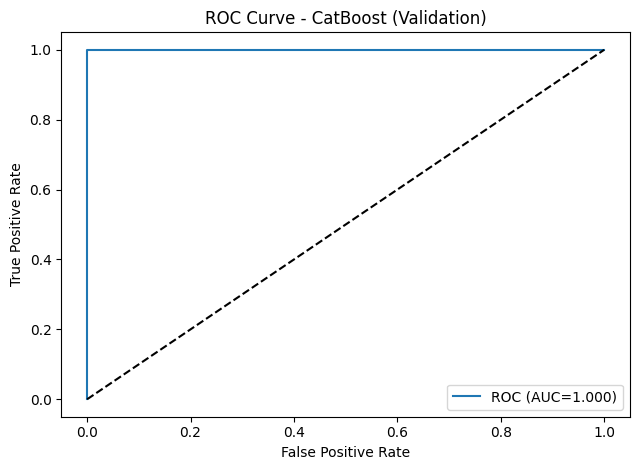

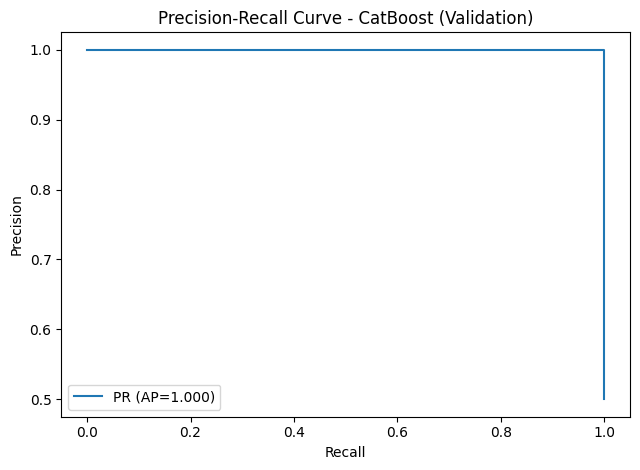


--- ผลลัพธ์การทำนาย (20 แถวแรก) ---
                                              Subject       Label  \
0   Exclusive Personal Relationship Opportunity Ju...  Legitimate   
1   Exceptional Work-From-Home Job Opportunity Awa...    Phishing   
2   Notification of Recent Account Activity - Acti...  Legitimate   
3   Exciting Work-from-Home Job Opportunity: Immed...    Phishing   
4   Exclusive Promotional Offer Just for You, Lind...  Legitimate   
5   Exclusive Promotional Offer from "Dynamic Glob...    Phishing   
6   Exciting Job Opportunity Awaits You at [Organi...  Legitimate   
7   Fantastic Work-From-Home Opportunity at BellaN...    Phishing   
8   Urgent Update Required for Your Health Managem...    Phishing   
9   Exciting Job Opportunity and Immediate Action ...    Phishing   
10        Immediate Job Opportunity at Tech Solutions    Phishing   
11        Important Technical Update - Security Alert    Phishing   
12  Important Account Notification - Please Review...  Legitimate 

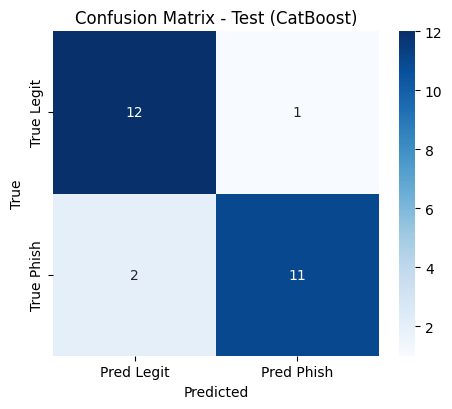


✅ บันทึกไฟล์: test_predictions_catboost_recall.csv


In [8]:
# ==============================
# 1) Import Libraries
# ==============================
import pandas as pd
import numpy as np

from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, classification_report, recall_score, precision_score,
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score,
    confusion_matrix, fbeta_score
)
from catboost import CatBoostClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


# ==============================
# 2) Load Data
# ==============================
TRAIN_URL = 'https://raw.githubusercontent.com/mildsupitcha25/MachineLearning_phishing_email/main/train.csv'
TEST_URL  = 'https://raw.githubusercontent.com/mildsupitcha25/MachineLearning_phishing_email/main/test.csv'  # ใช้ test.csv

print("กำลังโหลดข้อมูลจาก GitHub...")
train_df = pd.read_csv(TRAIN_URL)
test_df  = pd.read_csv(TEST_URL)
print("โหลดข้อมูลสำเร็จ!")
print(f"Train Shape: {train_df.shape}")
print(f"Test  Shape: {test_df.shape}")

# ==============================
# 3) Data Preparation
# ==============================
# รวม Subject + Body
train_df['FullText'] = train_df['Subject'].fillna('') + ' ' + train_df['Body'].fillna('')
test_df['FullText']  = test_df['Subject'].fillna('')  + ' ' + test_df['Body'].fillna('')

# เข้ารหัส label
label_mapping = {'Legitimate': 0, 'Phishing': 1}
train_df['label_num'] = train_df['Label'].map(label_mapping)
if train_df['label_num'].isna().any():
    bad = train_df.loc[train_df['label_num'].isna(), 'Label'].unique()
    raise ValueError(f"พบ Label ใน train ที่ไม่รู้จัก: {bad}")

X_text = train_df['FullText'].fillna('')
y      = train_df['label_num'].astype(int)

X_test_text = test_df['FullText'].fillna('')
test_has_label = False
y_test_true = None
if 'Label' in test_df.columns:
    test_df['label_num'] = test_df['Label'].map(label_mapping)
    if test_df['label_num'].isna().any():
        bad = test_df.loc[test_df['label_num'].isna(), 'Label'].unique()
        raise ValueError(f"พบ Label ใน test ที่ไม่รู้จัก: {bad}")
    y_test_true = test_df['label_num'].astype(int)
    test_has_label = True

# ==============================
# 4) TF-IDF: Word + Char (ไม่มี handcrafted features)
# ==============================
word_vec = TfidfVectorizer(
    stop_words='english',
    lowercase=True,
    max_features=40000,         # เพิ่มความละเอียด
    ngram_range=(1, 3),
    min_df=2,
    max_df=0.98,
    sublinear_tf=True
)
char_vec = TfidfVectorizer(
    analyzer='char',
    lowercase=True,
    ngram_range=(3, 5),
    min_df=2
)

X_word = word_vec.fit_transform(X_text)       # fit เฉพาะ train
X_char = char_vec.fit_transform(X_text)
X_all  = hstack([X_word, X_char]).tocsr()

X_word_test = word_vec.transform(X_test_text) # transform test
X_char_test = char_vec.transform(X_test_text)
X_test_all  = hstack([X_word_test, X_char_test]).tocsr()

print(f"TF-IDF Train Shape: {X_all.shape} | TF-IDF Test Shape: {X_test_all.shape}")

# ==============================
# 5) Train/Validation Split
# ==============================
X_tr, X_val, y_tr, y_val = train_test_split(
    X_all, y, test_size=0.2, random_state=42, stratify=y
)

# class weights เพื่อช่วยคลาส Phishing (imbalance)
pos = (y_tr == 1).sum()
neg = (y_tr == 0).sum()
class_weights = {0: 1.0, 1: float(neg / max(1, pos))}  # น้ำหนัก ~ neg/pos
print(f"class_weights = {class_weights}")

# ==============================
# 6) CatBoost Model + Early Stopping (เน้น Recall)
# ==============================
# ตั้งค่าเบื้องต้นให้เรียนรู้ลึกพอและหยุดเมื่อไม่ดีขึ้น
cat_base = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='AUC',              # ใช้ AUC เพื่อดูการแยกชั้น
    iterations=1500,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3.0,
    random_seed=42,
    verbose=False,
    class_weights=class_weights,    # ช่วยคลาส phishing
    od_type='Iter',
    od_wait=100                     # early stopping patience
)

# (ทางเลือก) Hyperparameter search แบบเบา ๆ เน้น recall/auc
# หมายเหตุ: CatBoost มีตัว tuner ในตัว แต่ในสคริปต์นี้จะใช้ค่าคงที่ปรับสมดุล
print("\nกำลังฝึกสอนโมเดล CatBoost (early stopping)...")
cat_base.fit(
    X_tr, y_tr,
    eval_set=(X_val, y_val),
    use_best_model=True
)
best_cat = cat_base  # ใช้โมเดลที่ดีที่สุดจาก early stopping

# ==============================
# 7) Validation Metrics + Threshold Tuning (ดัน Recall)
# ==============================
val_prob = best_cat.predict_proba(X_val)[:, 1]

# baseline @ 0.5
val_pred_05 = (val_prob >= 0.5).astype(int)
print("\n[Validation @ threshold=0.5]")
print("Accuracy :", accuracy_score(y_val, val_pred_05))
print("Recall   :", recall_score(y_val, val_pred_05))
print("Precision:", precision_score(y_val, val_pred_05, zero_division=0))
print("ROC-AUC  :", roc_auc_score(y_val, val_prob))
print("PR-AUC   :", average_precision_score(y_val, val_prob))
print(classification_report(y_val, val_pred_05, target_names=['Legitimate', 'Phishing']))

# ปรับ threshold เพื่อให้ Recall ≥ เป้าหมาย หรือ fallback ด้วย F2-optimal
TARGET_RECALL = 0.95
prec, rec, thr = precision_recall_curve(y_val, val_prob)

best_t = 0.5
best_prec = -1.0
for p, r, t in zip(prec[:-1], rec[:-1], thr):
    if r >= TARGET_RECALL and p > best_prec:
        best_prec = p
        best_t = t

if best_prec < 0:
    thresholds = np.linspace(0.05, 0.95, 181)
    f2_scores = [fbeta_score(y_val, (val_prob >= t).astype(int), beta=2) for t in thresholds]
    best_t = float(thresholds[int(np.argmax(f2_scores))])
    mode = f"(fallback) F2-optimal"
else:
    mode = f"(target recall ≥ {TARGET_RECALL:.2f})"

val_pred_best = (val_prob >= best_t).astype(int)
print(f"\n[Validation @ tuned threshold={best_t:.3f}] {mode}")
print("Accuracy :", accuracy_score(y_val, val_pred_best))
print("Recall   :", recall_score(y_val, val_pred_best))
print("Precision:", precision_score(y_val, val_pred_best, zero_division=0))
print(classification_report(y_val, val_pred_best, target_names=['Legitimate', 'Phishing']))

# ROC
fpr, tpr, _ = roc_curve(y_val, val_prob)
val_auc = roc_auc_score(y_val, val_prob)
plt.figure(figsize=(6.5, 4.8))
plt.plot(fpr, tpr, label=f'ROC (AUC={val_auc:.3f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve - CatBoost (Validation)')
plt.legend(); plt.tight_layout(); plt.show()

# PR
plt.figure(figsize=(6.5, 4.8))
plt.plot(rec, prec, label=f'PR (AP={average_precision_score(y_val, val_prob):.3f})')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Precision-Recall Curve - CatBoost (Validation)')
plt.legend(); plt.tight_layout(); plt.show()

# ==============================
# 8) Refit บน Train ทั้งหมด + Predict Test (ใช้ threshold ที่ tune)
# ==============================
final_cat = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='AUC',
    iterations=best_cat.tree_count_,  # ใช้จำนวนต้นไม้ที่ early stopped
    learning_rate=best_cat.get_param('learning_rate'),
    depth=best_cat.get_param('depth'),
    l2_leaf_reg=best_cat.get_param('l2_leaf_reg'),
    random_seed=42,
    verbose=False,
    class_weights=class_weights
).fit(X_all, y)

test_prob = final_cat.predict_proba(X_test_all)[:, 1]
test_pred = (test_prob >= best_t).astype(int)

submission_df = test_df.copy()
submission_df['Predicted_Prob_Phishing'] = test_prob
submission_df['Predicted_Label_Num']     = test_pred
rev_map = {0: 'Legitimate', 1: 'Phishing'}
submission_df['Predicted_Label'] = submission_df['Predicted_Label_Num'].map(rev_map)

# แสดงผล 20 แถวแรก
show_cols = ['Subject', 'Predicted_Label', 'Predicted_Prob_Phishing']
if test_has_label:
    show_cols.insert(1, 'Label')
print("\n--- ผลลัพธ์การทำนาย (20 แถวแรก) ---")
print(submission_df[show_cols].head(20))
print("\nจำนวนทั้งหมด:", len(submission_df))

# ===== Evaluate on TEST (ถ้ามี Label จริง) =====
if test_has_label:
    print("\n[Evaluation on TEST Set]")
    print(f"Threshold used: {best_t:.3f}")
    print("Accuracy :", accuracy_score(y_test_true, test_pred))
    print("Recall   :", recall_score(y_test_true, test_pred))
    print("Precision:", precision_score(y_test_true, test_pred, zero_division=0))
    print(classification_report(y_test_true, test_pred, target_names=['Legitimate', 'Phishing']))

    # Confusion Matrix
    cm = confusion_matrix(y_test_true, test_pred, labels=[0, 1])
    plt.figure(figsize=(4.8, 4.2))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred Legit', 'Pred Phish'],
                yticklabels=['True Legit', 'True Phish'])
    plt.title('Confusion Matrix - Test (CatBoost)')
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.tight_layout(); plt.show()
else:
    print("\n⚠️ Test set ไม่มี Label จริง จึงประเมิน metrics ไม่ได้ (แสดงเฉพาะผลทำนาย)")

# ==============================
# 9) Save Predictions
# ==============================
id_col = None
if 'Id' in test_df.columns: id_col = 'Id'
elif 'ID' in test_df.columns: id_col = 'ID'
else:
    submission_df['Index'] = submission_df.index
    id_col = 'Index'

out_cols = [id_col, 'Predicted_Label', 'Predicted_Prob_Phishing']
if test_has_label:
    out_cols.insert(1, 'Label')

final_submission = submission_df[out_cols]
final_submission.to_csv('test_predictions_catboost_recall.csv', index=False)
print("\n✅ บันทึกไฟล์: test_predictions_catboost_recall.csv")

#Logistic

กำลังโหลดข้อมูลจาก GitHub...
โหลดข้อมูลสำเร็จ!
Train Shape: (100, 3)
Test  Shape: (26, 3)
TF-IDF Train Shape: (100, 30711) | TF-IDF Test Shape: (26, 30711)

กำลังทำ Hyperparameter Tuning (เน้น Recall)...
Fitting 3 folds for each of 7 candidates, totalling 21 fits
Best Params: {'C': np.float64(2.1544346900318834)}

[Validation @ threshold=0.5]
Accuracy : 1.0
Recall   : 1.0
Precision: 1.0
ROC-AUC  : 1.0
PR-AUC   : 0.9999999999999999
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00        10
    Phishing       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20


[Validation @ tuned threshold=0.580] (target recall ≥ 0.95)
Accuracy : 1.0
Recall   : 1.0
Precision: 1.0
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00        10
    Phishing       1.00

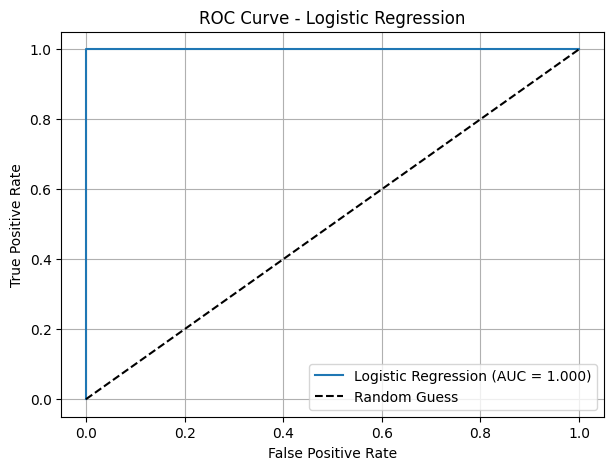

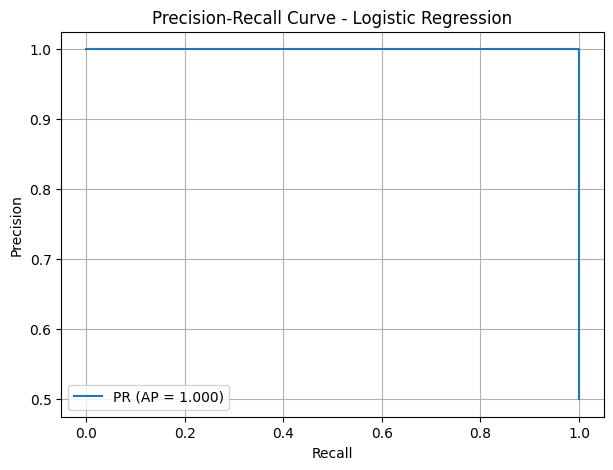


--- ผลลัพธ์การทำนาย (20 แถวแรก) ---
                                              Subject       Label  \
0   Exclusive Personal Relationship Opportunity Ju...  Legitimate   
1   Exceptional Work-From-Home Job Opportunity Awa...    Phishing   
2   Notification of Recent Account Activity - Acti...  Legitimate   
3   Exciting Work-from-Home Job Opportunity: Immed...    Phishing   
4   Exclusive Promotional Offer Just for You, Lind...  Legitimate   
5   Exclusive Promotional Offer from "Dynamic Glob...    Phishing   
6   Exciting Job Opportunity Awaits You at [Organi...  Legitimate   
7   Fantastic Work-From-Home Opportunity at BellaN...    Phishing   
8   Urgent Update Required for Your Health Managem...    Phishing   
9   Exciting Job Opportunity and Immediate Action ...    Phishing   
10        Immediate Job Opportunity at Tech Solutions    Phishing   
11        Important Technical Update - Security Alert    Phishing   
12  Important Account Notification - Please Review...  Legitimate 

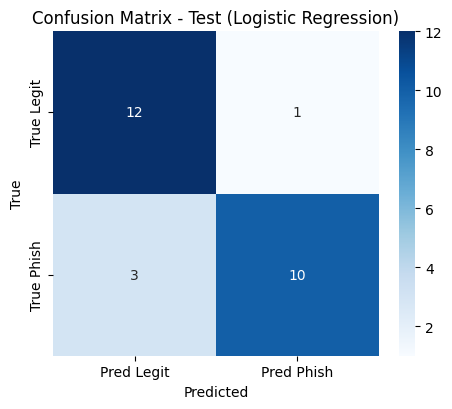


✅ บันทึกไฟล์: test_predictions_logistic_recall.csv


In [6]:
# ==============================
# 1) Import Libraries
# ==============================
import pandas as pd
import numpy as np

from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score, recall_score,
    precision_score, confusion_matrix, fbeta_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ==============================
# 2) Load Data
# ==============================
TRAIN_URL = 'https://raw.githubusercontent.com/mildsupitcha25/MachineLearning_phishing_email/main/train.csv'
TEST_URL  = 'https://raw.githubusercontent.com/mildsupitcha25/MachineLearning_phishing_email/main/test.csv'  # เปลี่ยนมาใช้ test.csv

print("กำลังโหลดข้อมูลจาก GitHub...")
train_df = pd.read_csv(TRAIN_URL)
test_df  = pd.read_csv(TEST_URL)
print("โหลดข้อมูลสำเร็จ!")
print(f"Train Shape: {train_df.shape}")
print(f"Test  Shape: {test_df.shape}")

# ==============================
# 3) Data Preparation
# ==============================
# รวม Subject + Body
train_df['FullText'] = train_df['Subject'].fillna('') + ' ' + train_df['Body'].fillna('')
test_df['FullText']  = test_df['Subject'].fillna('')  + ' ' + test_df['Body'].fillna('')

# เข้ารหัส label
label_mapping = {'Legitimate': 0, 'Phishing': 1}
train_df['label_num'] = train_df['Label'].map(label_mapping)
if train_df['label_num'].isna().any():
    bad = train_df.loc[train_df['label_num'].isna(), 'Label'].unique()
    raise ValueError(f"พบ Label ใน train ที่ไม่รู้จัก: {bad}")

X_text = train_df['FullText'].fillna('')
y      = train_df['label_num'].astype(int)

X_test_text = test_df['FullText'].fillna('')
test_has_label = False
y_test_true = None
if 'Label' in test_df.columns:
    test_df['label_num'] = test_df['Label'].map(label_mapping)
    if test_df['label_num'].isna().any():
        bad = test_df.loc[test_df['label_num'].isna(), 'Label'].unique()
        raise ValueError(f"พบ Label ใน test ที่ไม่รู้จัก: {bad}")
    y_test_true = test_df['label_num'].astype(int)
    test_has_label = True

# ==============================
# 4) TF-IDF: Word + Char (ไม่มี handcrafted features)
# ==============================
word_vec = TfidfVectorizer(
    stop_words='english',
    lowercase=True,
    max_features=40000,         # เพิ่มความละเอียด
    ngram_range=(1, 3),
    min_df=2,
    max_df=0.98,
    sublinear_tf=True
)
char_vec = TfidfVectorizer(
    analyzer='char',
    lowercase=True,
    ngram_range=(3, 5),
    min_df=2
)

X_word = word_vec.fit_transform(X_text)       # fit เฉพาะ train (หลีกเลี่ยง leakage)
X_char = char_vec.fit_transform(X_text)
X_all  = hstack([X_word, X_char]).tocsr()

X_word_test = word_vec.transform(X_test_text) # transform test
X_char_test = char_vec.transform(X_test_text)
X_test_all  = hstack([X_word_test, X_char_test]).tocsr()

print(f"TF-IDF Train Shape: {X_all.shape} | TF-IDF Test Shape: {X_test_all.shape}")

# ==============================
# 5) Train/Validation Split
# ==============================
X_tr, X_val, y_tr, y_val = train_test_split(
    X_all, y, test_size=0.2, random_state=42, stratify=y
)

# ==============================
# 6) Logistic Regression (balanced) + Tuning for Recall
# ==============================
base_lr = LogisticRegression(
    solver='saga',             # รองรับ L1/L2 และทำงานดีกับ sparse
    penalty='l2',
    class_weight='balanced',   # โอเวอร์เวทคลาส Phishing
    max_iter=5000,
    n_jobs=-1,
    random_state=42
)

param_dist = {
    'C': np.logspace(-1, 1, 7)  # [0.1 .. 10]
}

print("\nกำลังทำ Hyperparameter Tuning (เน้น Recall)...")
search = RandomizedSearchCV(
    estimator=base_lr,
    param_distributions=param_dist,
    n_iter=10,
    scoring='recall',          # โฟกัส Recall ของคลาส 1
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)
search.fit(X_tr, y_tr)

best_lr = search.best_estimator_
print("Best Params:", search.best_params_)

# ==============================
# 7) Validation Metrics + Threshold Tuning (ดัน Recall)
# ==============================
val_prob = best_lr.predict_proba(X_val)[:, 1]

# baseline @ threshold=0.5
val_pred_05 = (val_prob >= 0.5).astype(int)
print("\n[Validation @ threshold=0.5]")
print("Accuracy :", accuracy_score(y_val, val_pred_05))
print("Recall   :", recall_score(y_val, val_pred_05))
print("Precision:", precision_score(y_val, val_pred_05, zero_division=0))
print("ROC-AUC  :", roc_auc_score(y_val, val_prob))
print("PR-AUC   :", average_precision_score(y_val, val_prob))
print(classification_report(y_val, val_pred_05, target_names=['Legitimate', 'Phishing']))

# ปรับ threshold เพื่อดัน Recall ให้สูง (เช่น ≥ 0.95) หรือ fallback ด้วย F2
TARGET_RECALL = 0.95
prec, rec, thr = precision_recall_curve(y_val, val_prob)

best_t = 0.5
best_prec = -1.0
for p, r, t in zip(prec[:-1], rec[:-1], thr):
    if r >= TARGET_RECALL and p > best_prec:
        best_prec = p
        best_t = t

if best_prec < 0:
    # Fallback: maximize F2 ซึ่งให้ความสำคัญกับ Recall มากกว่า Precision
    thresholds = np.linspace(0.05, 0.95, 181)
    f2_scores = [fbeta_score(y_val, (val_prob >= t).astype(int), beta=2) for t in thresholds]
    best_t = float(thresholds[int(np.argmax(f2_scores))])
    mode = f"(fallback) F2-optimal"
else:
    mode = f"(target recall ≥ {TARGET_RECALL:.2f})"

val_pred_best = (val_prob >= best_t).astype(int)
print(f"\n[Validation @ tuned threshold={best_t:.3f}] {mode}")
print("Accuracy :", accuracy_score(y_val, val_pred_best))
print("Recall   :", recall_score(y_val, val_pred_best))
print("Precision:", precision_score(y_val, val_pred_best, zero_division=0))
print(classification_report(y_val, val_pred_best, target_names=['Legitimate', 'Phishing']))

# ROC Curve
fpr, tpr, _ = roc_curve(y_val, val_prob)
auc_score = roc_auc_score(y_val, val_prob)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression'); plt.legend(loc='lower right'); plt.grid(True)
plt.show()

# PR Curve
plt.figure(figsize=(7, 5))
plt.plot(rec, prec, label=f'PR (AP = {average_precision_score(y_val, val_prob):.3f})')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Logistic Regression')
plt.legend(loc='lower left'); plt.grid(True)
plt.show()

# ==============================
# 8) Refit บน Train ทั้งหมด + Predict Test (ใช้ threshold ที่ tune)
# ==============================
final_lr = LogisticRegression(
    solver='saga',
    penalty='l2',
    class_weight='balanced',
    max_iter=5000,
    n_jobs=-1,
    random_state=42,
    C=search.best_params_['C']
).fit(X_all, y)

test_prob = final_lr.predict_proba(X_test_all)[:, 1]
test_pred = (test_prob >= best_t).astype(int)

submission_df = test_df.copy()
submission_df['Predicted_Prob_Phishing'] = test_prob
submission_df['Predicted_Label_Num']     = test_pred
rev_map = {0: 'Legitimate', 1: 'Phishing'}
submission_df['Predicted_Label'] = submission_df['Predicted_Label_Num'].map(rev_map)

# แสดงผล 20 แถวแรก
show_cols = ['Subject', 'Predicted_Label', 'Predicted_Prob_Phishing']
if test_has_label:
    show_cols.insert(1, 'Label')
print("\n--- ผลลัพธ์การทำนาย (20 แถวแรก) ---")
print(submission_df[show_cols].head(20))
print("\nจำนวนทั้งหมด:", len(submission_df))

# ===== Evaluate on TEST (ถ้ามี Label จริง) =====
if test_has_label:
    print("\n[Evaluation on TEST Set]")
    print(f"Threshold used: {best_t:.3f}")
    print("Accuracy :", accuracy_score(y_test_true, test_pred))
    print("Recall   :", recall_score(y_test_true, test_pred))
    print("Precision:", precision_score(y_test_true, test_pred, zero_division=0))
    print(classification_report(y_test_true, test_pred, target_names=['Legitimate', 'Phishing']))

    # Confusion Matrix
    cm = confusion_matrix(y_test_true, test_pred, labels=[0, 1])
    plt.figure(figsize=(4.8, 4.2))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred Legit', 'Pred Phish'],
                yticklabels=['True Legit', 'True Phish'])
    plt.title('Confusion Matrix - Test (Logistic Regression)')
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.tight_layout(); plt.show()
else:
    print("\n⚠️ Test set ไม่มี Label จริง จึงประเมิน metrics ไม่ได้ (แสดงเฉพาะผลทำนาย)")

# ==============================
# 9) Save Predictions
# ==============================
id_col = None
if 'Id' in test_df.columns: id_col = 'Id'
elif 'ID' in test_df.columns: id_col = 'ID'
else:
    submission_df['Index'] = submission_df.index
    id_col = 'Index'

out_cols = [id_col, 'Predicted_Label', 'Predicted_Prob_Phishing']
if test_has_label:
    out_cols.insert(1, 'Label')

final_submission = submission_df[out_cols]
final_submission.to_csv('test_predictions_logistic_recall.csv', index=False)
print("\n✅ บันทึกไฟล์: test_predictions_logistic_recall.csv")